# Catalogue of books
A friend of mine has collected books for many years and has recently begun to catalogue them. In this post I do some simple analysis of the catalogue and query an ISBN database to fill in some missing data. 

### Set-up and data preparation 
Set some settings and import some command libraries

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font color=#33cc33><i>To toggle the visibility of the code blocks, click <a href="javascript:code_toggle()">here</a>.</i></font>''')

In [2]:
# Display plot results inline, not in a separate window
%matplotlib inline
%pylab inline

# Set the size of all figures
pylab.rcParams['figure.figsize'] = (14, 5)

import pandas as pd
import re
import bibtexparser

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Load the catalogue file:

In [3]:
table = pd.read_excel('Library.xlsx')
table = table[0:9188]
df = table
orig_rows = (df.shape[0])

print("There are %d rows in the catalogue" % (df.shape[0]) )

There are 9187 rows in the catalogue


### Data formatting and tidying:

View the top 5 rows to see how the data is arranged and how many cells are complete.

In [4]:
df.head()

,Location,Subject,Title,Author,Publisher,ISBN?,Shelf,Pages,Price,Value,Date
0,HR,Islam,The Islamic Invasion,R Morey,Harvest HP 1960,0 89081 983 1,17cm,221,3,8,2008-04-01 00:00:00
1,HR,Word lists,New Testament Word Lists,Morrison & Barnes,Erdmans 1975,0 8028 1141 8,NaN,125,3,NaN,2008-04-01 00:00:00
2,HR,Theology: Salvation,The Triumph of the crucified,E Sauer,Paternoster 1952,NaN,NaN,207,3,10,2008-04-01 00:00:00
3,HR,Early Fathers,Ante-Nicene Christian Library,Ed Menzies,T&T Clark 1897,NaN,NaN,533,9,NaN,2010-03-01 00:00:00
4,HR,Apologetics,Earth's earliest ages,G.H. Pember,H & S 1895,NaN,NaN,494,3,NaN,2008-04-01 00:00:00


Set float format to two decimal places (currency). Not all rows can become a float:

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

def to_number(s): 
    try:
        s1 = round(float(s),2)
        return s1
    except ValueError:
        return s
    
df.Price = df.Price.map(lambda f : to_number(f))  
df.Value = df.Value.map(lambda f : to_number(f))  

Find and remove blank rows:

In [6]:
# How many rows are all NaN values
df = df.dropna(how='all')              # drop a row only if ALL columns are NaN
print('%d row removed ' % (orig_rows - df.shape[0]) ) # 1 row contained all NaN and has been removed

1 row removed 


List the number of rows in each column which are empty:

In [7]:
# How many rows in each column are NaN
df.isnull().sum().sort_values()

Location       29
Title          34
Publisher     175
Shelf         336
Pages         540
Author        915
Price        3611
ISBN?        4770
Date         5712
Subject      6208
Value        9179
dtype: int64

_Based on these results, title and publisher are the most complete columns_

Split a column containing two types of data:

The "Publisher" column contains both the publisher and the year it was published. This should be split into two columns. 

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'
df['PubYear'] = df['Publisher'].str.extract('(\d\d\d\d)', expand=True)          # regex is confusing
df['Publisher'] = df['Publisher'].str.extract('(((?!\d).)*)', expand=True)

Improve the format of the 'Date' column:

In [9]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

The data frame is now in the columns I want it to be in, and the top 5 rows are:

In [10]:
df.head()

,Location,Subject,Title,Author,Publisher,ISBN?,Shelf,Pages,Price,Value,Date,PubYear
0,HR,Islam,The Islamic Invasion,R Morey,Harvest HP,0 89081 983 1,17cm,221,3.00,8.00,2008-04-01,1960
1,HR,Word lists,New Testament Word Lists,Morrison & Barnes,Erdmans,0 8028 1141 8,NaN,125,3.00,NaN,2008-04-01,1975
2,HR,Theology: Salvation,The Triumph of the crucified,E Sauer,Paternoster,NaN,NaN,207,3.00,10.00,2008-04-01,1952
3,HR,Early Fathers,Ante-Nicene Christian Library,Ed Menzies,T&T Clark,NaN,NaN,533,9.00,NaN,2010-03-01,1897
4,HR,Apologetics,Earth's earliest ages,G.H. Pember,H & S,NaN,NaN,494,3.00,NaN,2008-04-01,1895


### Insights

Distribution of books by year published:

The bar chart below shows how many books in the library were published in a given decade. The list below shows the 5 oldest books.

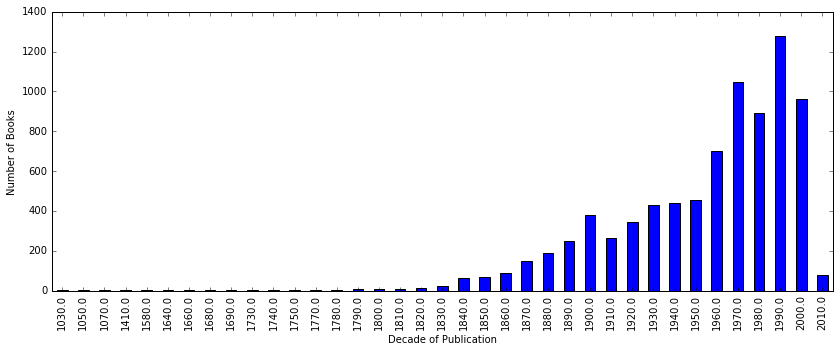

In [11]:
pd.options.display.float_format = '{:,}'.format
df.PubYear = pd.to_numeric(df.PubYear, errors='ignore')
fig = df.groupby(df.PubYear // 10 * 10).size().plot(kind='bar', xlim=[1000,2016], logy = False)
fig.set_xlabel("Decade of Publication")
fig.set_ylabel("Number of Books")
fig

View the 5 oldest titles:

In [12]:
df['PubYear'] = df['PubYear'].fillna(0.0).astype(int)
df2 = df[df['PubYear'] != 0.0]
df2.sort_values(by='PubYear').head()

,Location,Subject,Title,Author,Publisher,ISBN?,Shelf,Pages,Price,Value,Date,PubYear
4753,Lib,NaN,In Christ's own country,Dom Ernest Graf,Burns Oates,NaN,Sh.4.5,302,Gift,NaN,1999-07-30,1037
3043,StM,NaN,The First Epistle of Peter,C.E.B. Cranfield,SCM Press,interesting,Sh.5.5,128,NaN,NaN,NaT,1050
4574,Lib,Music Score,Easy-Play Speed Music; waltz clas,NaN,Sight & Sound,NaN,Sh.4.4,47,99P,NaN,NaT,1076
7184,25A,NaN,The Noble Qur'an,transl Al-Hilali & Khan,Madinah,NaN,Sh.3.6,956,3.0,NaN,2010-12-10,1417
3296,Lib,NaN,Chained Bible,NaN,Chris Barker,Very incomplete,Sh.1.1,NaN,NaN,NaN,NaT,1585


List the number of books in each location:

In [13]:
df3 = df
df3["Location"] = df3["Location"].astype(str).map(str.strip).str.upper().str.slice(0,5)
df3.groupby(df3.Location).size().sort_values(ascending=False)

Location
25A      3411
LIB      2457
CH       1088
ST9      1000
STM       886
HR        305
NAN        29
ST.M        3
HR          2
ST M        1
SA          1
LB          1
CH          1
:LIB        1
dtype: int64

Create a list of the differnet subjects, order the list by the most frequent subjects:

In [14]:
df4 = df
df4["Subject"] = df4["Subject"].astype(str).map(str.strip).str.upper()
df4.groupby(df4.Subject).size().sort_values(ascending=False).head(50)

Subject
NAN                            6208
COMMENTARY                       61
LOCAL HISTORY                    58
SERMONS                          41
THE CENTURY BIBLE                37
THEOLOGY                         36
CHRISTIAN BIOGRAPHY              34
BIOGRAPHY                        31
NT COMMENTARY                    31
HEBREW GRAMMAR                   30
SACRED BOOKS OF THE EAST         30
POETRY                           29
CLARK'S FOREIGN THEOL LIB        28
GENERAL EDIT ANTONIA FRAZER      25
NOVEL                            24
WRITERS AND THEIR WORK           24
CATALOGUE                        22
AUTOBIOGRAPHY                    20
OT COMMENTARY                    19
GREEK                            19
THE EXPOSITOR'S BIBLE            18
SRIMAD BHAGAVATAM                18
THE BABYLONIAN TALMUD            18
PHOTOGRAPHS                      17
GREAT MUSEUMS OF T WORLD         15
CHURCH HISTORY                   14
DAILY READINGS                   14
CHRISTIAN LECTURES  

Create a list of authors in the library. Order the list by number of books:

In [15]:
df5 = df
df5["Author"] = df5["Author"].astype(str).map(str.strip).str.upper() #.str.slice(0,20)
df5.groupby(df5.Author).size().sort_values(ascending=False).head(50)

Author
NAN                     915
VARIOUS                  31
BHAKTIVEDANTA S PRAB     19
C.H. SPURGEON            19
ELLIS PETERS             17
ED. RABBI I. EPSTEIN     17
LESLIE WEATHERHEAD       15
ED CARLO RAGGHIANTI      15
ALBERT BARNES            14
JAMES HASTINGS           13
GEORGE ADAM SMITH        13
WILLIAM TEMPLE           12
JAMES MOFFATT            11
ED J A HAMMERTON         11
KEIL & DELITZSCH         11
WILLIAM BARCLAY          10
SHAKESPEARE              10
PETER ACKROYD            10
IAN WILSON                9
CHARLES DICKENS           9
BERNHARD WEISS            9
J.B. PHILLIPS             9
ED QUENNELL & HODGE       8
CHARLES GORE              8
H.V. MORTON               8
M.F. SADLER               8
VARIOUS AUTHORS           8
ED ANDREW LANG            8
GEZA VERMES               8
S.R. DRIVER               8
EVELYN UNDERHILL          8
"                         8
HENRY ALFORD              7
ALDOUS HUXLEY             7
ED JAMES HASTINGS         7
ED ARTHUR MEE

Distribution of book length by number of pages:

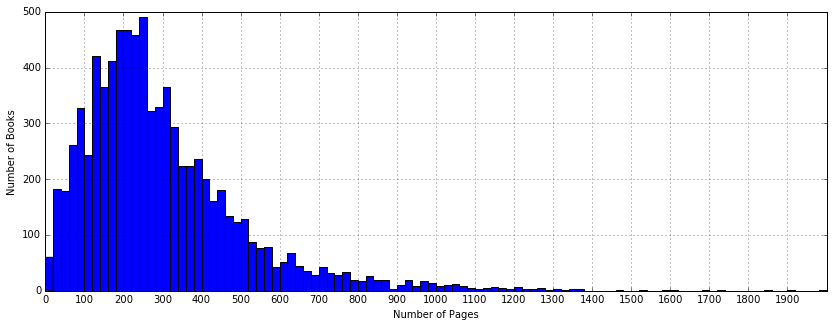

In [16]:
def blank_or_number(s): 
    try:
        s1 = round(float(s),2)
        return s1
    except ValueError:
        return ''
    
    
df.Pages = df.Pages.map(lambda f : blank_or_number(f)) 
df6 = df.Pages[df.Pages != '']

plt.xticks(np.arange(0, 2000, 100.0))
fig = df6.hist(bins=100, range=[0, 2000])
fig.set_xlabel("Number of Pages")
fig.set_ylabel("Number of Books")


Query an ISBN database to find missing data:

Lastly, I thought it would be a fun challenge to fill in gaps in the data. The table below shows rows with ISBN number but missing either Author, Title or Publisher.

It turns out that there are only 10 rows that meet this criteria, and in all cases it is the publisher that is missing. 

In [17]:
df7 = df[(df['ISBN?'].notnull()) & ((df['Author'] == '') | (df['Title'] == '') | (df['Publisher'] == ''))]
df7

,Location,Subject,Title,Author,Publisher,ISBN?,Shelf,Pages,Price,Value,Date,PubYear
1430,ST9,BIOGRAPHY OF SCIENTIST,Longitude (John Harrison),DAVA SOBEL,,1 85702 571 7,Sh.1.2,184.0,5.99,NaN,NaT,1998
2707,STM,DEVOTIONAL!,Romans: Momentous News,DAVID COOK,,978 1 906173241,Sh.3.4,55.0,1.0,NaN,2011-07-28,2011
3874,LIB,NAN,Annie's Box - Darwin's daughter,RANDAL KEYNES,,1 84115 060 6,Sh.2.4,331.0,3.99,NaN,2002-07-20,2001
4705,LIB,HISTORICAL NOVEL,Galileo's Daughter,DAVA SOBEL,,1 85702 861 9,Sh.4.5,429.0,NaN,NaN,2002-09-27,1999
5949,25A,NAN,Short Life Long Times of Mrs Beeton,KATHRYN HUGHES,,1 84115 373 7,Sh.1.4,525.0,£2.50P,NaN,2012-02-09,2005
6008,25A,NAN,Signs in the Sky (Birth of a New Age,ADRIAN GILBERT,,0 609 80793 5,Sh.1.5,329.0,4.0,NaN,2012-03-07,2001
6097,25A,NAN,"Isaac Newton, the last Sorcerer",MICHAEL WHITE,,1 85702 706 X,Sh.1.6,403.0,£1.50P,NaN,2012-02-09,1997
6663,25A,NAN,Live Wires - powerful stories of cha,D. J. CARSWELL,,978 1 906173 13 5,Sh.2.7,124.0,1.0,NaN,2011-06-29,2010
8640,25A,KING ARTHUR QUINCENTENARY,One in Specyal,ED SIDNEY HART,,0 948485 00 0,Sh.5.9,145.0,£2.49P,NaN,2003-06-28,1985
8845,25A,NAN,The Order of St John - a short history,E L EDMONDS,,0 947718 07 9,Sh.5.7b,35.0,£3.75P,NaN,NaT,1986


In [18]:
from isbnlib import *
from isbnlib.config import * 
from isbnlib.registry import * 
import bibtexparser

def has_isbn(isbn):
    SERVICE = 'isbndb'
    APIKEY = 'IZXL3ESD'  # YOUR key
    add_apikey(SERVICE, APIKEY) # register your key
    bibtex = bibformatters['bibtex']
    isbn = clean(isbn)
    try:
        a = bibtex(meta(EAN13(isbn), SERVICE))
        return a
    except:
        return 'isbn is invalid'

In [19]:
def get_pub(isbn):
    bibtex_str = has_isbn(isbn)
    try:
        bib_db = bibtexparser.loads(bibtex_str)
        dic = bib_db.entries[0]
        return dic['publisher']
    except:
        return


In [20]:
df7['ISBN?'] = df7['ISBN?'].astype(str)
df7.Publisher = df7['ISBN?'].map(lambda f : get_pub(f))

The table below shows the results of the isbnlib query. I thought it odd that all the 'missing' publishers names began with a number. It turns out that the regex method I used to split publisher name and year of publication into separate columns doesnt work when there are numbers in the publishers name. Rather than go back and correct this, I'll leave the script as it is to show how to use the isbnlib library.  

In [21]:
df7

,Location,Subject,Title,Author,Publisher,ISBN?,Shelf,Pages,Price,Value,Date,PubYear
1430,ST9,BIOGRAPHY OF SCIENTIST,Longitude (John Harrison),DAVA SOBEL,Fourth Estate,1 85702 571 7,Sh.1.2,184.0,5.99,NaN,NaT,1998
2707,STM,DEVOTIONAL!,Romans: Momentous News,DAVID COOK,10Publishing,978 1 906173241,Sh.3.4,55.0,1.0,NaN,2011-07-28,2011
3874,LIB,NAN,Annie's Box - Darwin's daughter,RANDAL KEYNES,4th Estate,1 84115 060 6,Sh.2.4,331.0,3.99,NaN,2002-07-20,2001
4705,LIB,HISTORICAL NOVEL,Galileo's Daughter,DAVA SOBEL,Fourth Estate,1 85702 861 9,Sh.4.5,429.0,NaN,NaN,2002-09-27,1999
5949,25A,NAN,Short Life Long Times of Mrs Beeton,KATHRYN HUGHES,None,1 84115 373 7,Sh.1.4,525.0,£2.50P,NaN,2012-02-09,2005
6008,25A,NAN,Signs in the Sky (Birth of a New Age,ADRIAN GILBERT,Three Rivers Press,0 609 80793 5,Sh.1.5,329.0,4.0,NaN,2012-03-07,2001
6097,25A,NAN,"Isaac Newton, the last Sorcerer",MICHAEL WHITE,Fourth Estate,1 85702 706 X,Sh.1.6,403.0,£1.50P,NaN,2012-02-09,1997
6663,25A,NAN,Live Wires - powerful stories of cha,D. J. CARSWELL,None,978 1 906173 13 5,Sh.2.7,124.0,1.0,NaN,2011-06-29,2010
8640,25A,KING ARTHUR QUINCENTENARY,One in Specyal,ED SIDNEY HART,Three Golden Crowns,0 948485 00 0,Sh.5.9,145.0,£2.49P,NaN,2003-06-28,1985
8845,25A,NAN,The Order of St John - a short history,E L EDMONDS,s.n,0 947718 07 9,Sh.5.7b,35.0,£3.75P,NaN,NaT,1986
